<a href="https://colab.research.google.com/github/JraHike76/Build-Week-Unit-2/blob/master/seattle_air_bnb_reviews__2016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recommendations for Air BnB's in Seattle from data scraped in 2016
* Original zip file can be found at https://www.kaggle.com/airbnb/seattle/data
* I am only using listings.csv which contained the most relevant information

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [ ]:
# Importing all libraries

%matplotlib inline
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import numpy as np

import eli5
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot

from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import FunctionTransformer
import sklearn; sklearn.__version__
from sklearn.cluster import KMeans ,AgglomerativeClustering
from eli5.sklearn import PermutationImportance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from ipywidgets import interact
import category_encoders as ce
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from collections import OrderedDict
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from itertools import groupby
from math import sqrt
from numpy import linalg  
from mpl_toolkits import mplot3d
from numpy.linalg import matrix_rank
import graphviz
from sklearn.tree import export_graphviz

In [ ]:
# GIT HUB URL from listing.csv 
# downloaded dataset zip file https://www.kaggle.com/airbnb/seattle/data

df = pd.read_csv('https://raw.githubusercontent.com/JraHike76/Build-Week-Unit-2/master/listings.csv')

___
## Inspecting the data

In [ ]:
# The dirty dataset

print(df.shape)
df.head()

(3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,

In [ ]:
# Let's inspect!

df.describe(include='number')

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [ ]:
df.describe(exclude='number')

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,calendar_updated,has_availability,calendar_last_scraped,first_review,last_review,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
count,3818,3818,3818,3641,3249,3818,3818,2786,2212,2884,3498,3498,3818,3498,3818,3816,3816,3810,2959,3295,3295,3045,3816,3816,3816,3518,3818,3816,3816,3818,3402,3818,3818,3818,3818,3811,3818,3818,3818,3818,3818,3817,3818,3818,3818,3818,2009,1517,1866,2788,3818,3818,3818,3818,3191,3191,3818,3818,3818,3818,3818,3818
unique,3818,1,3792,3478,3119,3742,1,2506,1999,2574,3498,3498,3818,3498,2751,1466,1380,120,2011,4,45,2,2,2743,2743,102,116,2,2,1442,81,87,17,7,2,28,1,7,1,1,2,16,3,5,3284,273,395,356,46,118,45,34,1,1,984,321,1,1,2,3,2,2
top,https://www.airbnb.com/rooms/5978216,2016-01-04,Capitol Hill Apartment,This is a modern fully-furnished studio apartm...,"*Note: This fall, there will be major renovati...",Our space is a mix of a hostel and a home. We ...,none,Wallingford is a mostly-residential neighborho...,All of our rentals are fully licensed and regu...,Convenient public transportation. The location...,https://a1.muscache.com/ac/pictures/93719987/e...,https://a2.muscache.com/im/pictures/b0d8ce4f-6...,https://a2.muscache.com/ac/pictures/1bd52efb-1...,https://a2.muscache.com/ac/pictures/a1927b5d-f...,https://www.airbnb.com/users/show/8534462,Andrew,2013-08-30,"Seattle, Washington, United States",It would be my pleasure to share and explore t...,within an hour,100%,100%,f,https://a2.muscache.com/ac/pictures/a4d7d053-c...,https://a2.muscache.com/ac/pictures/a4d7d053-c...,Capitol Hill,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"1st Avenue, Seattle, WA 98101, United States",Capitol Hill,Broadway,Other neighborhoods,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,t,House,Entire home/apt,Real Bed,{},$150.00,$500.00,"$2,500.00",$100.00,$50.00,$0.00,today,t,2016-01-04,2015-09-21,2016-01-02,f,WASHINGTON,f,strict,f,f
freq,1,3818,3,15,14,10,3818,17,39,32,1,1,1,1,46,56,51,3259,46,1692,2371,3044,3038,46,46,405,595,3809,2997,30,351,397,794,3810,3817,420,3818,3810,3818,3818,3412,1733,2541,3657,45,162,94,66,348,310,2048,706,3818,3818,25,94,3818,3818,3227,1417,3497,3443


In [ ]:
# Let's look at all 92 columns!

df.describe(include='all')

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3818,3.818000e+03,3818,3818,3641,3249,3818,3818,2786,2212,2884,3498,3498,3818,3498,3.818000e+03,3818,3816,3816,3810,2959,3295,3295,3045,3816,3816,3816,3518,3816.000000,3816.000000,3818,3816,3816,3818,3402,3818,3818,3818,3818,...,3812.000000,3817.000000,3818,3818,97.000000,3818,2009,1517,1866,2788,3818.000000,3818,3818.000000,3818.000000,3818,3818,3818.000000,3818.000000,3818.000000,3818.000000,3818,3818.000000,3191,3191,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3818,0.0,3818,3818,3818,3818,3818,3818.000000,3191.000000
unique,NaN,3818,NaN,1,3792,3478,3119,3742,1,2506,1999,2574,3498,3498,3818,3498,NaN,2751,1466,1380,120,2011,4,45,2,2,2743,2743,102,NaN,NaN,116,2,2,1442,81,87,17,7,2,...,NaN,NaN,5,3284,NaN,273,395,356,46,118,NaN,45,NaN,NaN,34,1,NaN,NaN,NaN,NaN,1,NaN,984,321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,2,3,2,2,NaN,NaN
top,NaN,https://www.airbnb.com/rooms/5978216,NaN,2016-01-04,Capitol Hill Apartment,This is a modern fully-furnished studio apartm...,"*Note: This fall, there will be major renovati...",Our space is a mix of a hostel and a home. We ...,none,Wallingford is a mostly-residential neighborho...,All of our rentals are fully licensed and regu...,Convenient public transportation. The location...,https://a1.muscache.com/ac/pictures/93719987/e...,https://a2.muscache.com/im/pictures/b0d8ce4f-6...,https://a2.muscache.com/ac/pictures/1bd52efb-1...,https://a2.muscache.com/ac/pictures/a1927b5d-f...,NaN,https://www.airbnb.com/users/show/8534462,Andrew,2013-08-30,"Seattle, Washington, United States",It would be my pleasure to share and explore t...,within an hour,100%,100%,f,https://a2.muscache.com/ac/pictures/a4d7d053-c...,https://a2.muscache.com/ac/pictures/a4d7d053-c...,Capitol Hill,NaN,NaN,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"1st Avenue, Seattle, WA 98101, United States",Capitol Hill,Broadway,Other neighborhoods,Seattle,WA,...,NaN,NaN,Real Bed,{},NaN,$150.00,$500.00,"$2,500.00",$100.00,$50.00,NaN,$0.00,NaN,NaN,today,t,NaN,NaN,NaN,NaN,2016-01-04,NaN,2015-09-21,2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,WASHINGTON,f,strict,f,f,NaN,NaN
freq,NaN,1,NaN,3818,3,15,14,10,3818,17,39,32,1,1,1,1,NaN,46,56,51,3259,46,1692,2371,3044,3038,46,46,405,NaN,NaN,595,3809,2997,30,351,397,794,3810,3817,...,NaN,NaN,3657,45,NaN,162,94,66,348,310,NaN,2048,NaN,NaN,706,3818,NaN,NaN,NaN,NaN,3818,NaN,25,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3818,NaN,3818,3227,1417,3497,3443,NaN,NaN
mean,5.550111e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.578556e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.157757,7.157757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.307712,1.735394,NaN,NaN,854.618557,NaN,NaN,NaN,NaN,NaN,1.67260

In [ ]:
# Before inspecting any further I have an idea for a target
# The review_scores_rating column is already broken down into percentages based on all ratings
# but further exploration is needed

## Pandas Profile Report

In [ ]:
# Let's look at the Pandas Profile Report

# profile = ProfileReport(df, minimal=True).to_notebook_iframe()

## Some important information from the Pandas Profile Report
* with 92 columns there was a lot to analyze
* 78 warnings including constant variable, high cardinality, unsupported, missing values, and zeros.
* There is going to be a lot of cleaning up to do
## An overview
![profile overview](https://i.imgur.com/e1vbUu4.png)
## My potential target (doesn't look too bad!)
![review_scores_rating](https://i.imgur.com/sg1pX2H.png)



In [ ]:
# taking the warnings into consideration I would like to see the columns
# and drop the ones that are truly unnecessary

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [ ]:
df['id'].head()

0     241032
1     953595
2    3308979
3    7421966
4     278830
Name: id, dtype: int64

In [ ]:
# id is an important feature for referencing each property
# I will rename it for clarification

df['property_id'] = df['id'] 

df = df.drop(columns=['id'])

In [ ]:
df['property_id'].head()

0     241032
1     953595
2    3308979
3    7421966
4     278830
Name: property_id, dtype: int64

___
## Time to drop columns, specifically ones of little use and categories with high cardinality

In [ ]:
# I will inspect columns by dtypes

df.select_dtypes('object').columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_s

In [ ]:
# from this array I will be dropping URL's, columns with 1 unique identifier,
#   duplicates and most columns with high cardinality, variance or randomness.

df = df.drop(columns =['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'thumbnail_url', 'medium_url', 'picture_url', 'street', 'amenities',
       'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', 
       'host_neighbourhood','host_name',  'neighbourhood', 'transit',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'host_location', 'host_about', 'weekly_price', 'monthly_price', 
       'security_deposit', 'cleaning_fee', 'extra_people', 'last_review',
       'host_verifications', 'host_has_profile_pic',  'first_review', 
       'smart_location', 'country_code', 'calendar_updated', 'has_availability',
       'calendar_last_scraped', 'jurisdiction_names', 'instant_bookable', 
       'require_guest_profile_picture','require_guest_phone_verification', 
       'host_since'])

In [ ]:
df.select_dtypes('float64').columns

Index(['host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'beds', 'square_feet',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'reviews_per_month'],
      dtype='object')

In [ ]:
# from this array I will be dropping columns with variance or randomness.

df = df.drop(columns =['host_listings_count', 'host_total_listings_count', 'license'])

In [ ]:
df.select_dtypes('int64').columns

Index(['scrape_id', 'host_id', 'accommodates', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'calculated_host_listings_count', 'property_id'],
      dtype='object')

In [ ]:
# from this array I will be dropping columns with variance or 1 unique identifier

df = df.drop(columns =['scrape_id', 'host_id', 'availability_30',
       'availability_60', 'availability_90', 'availability_365'])

In [ ]:
# anything that is missing will become a nan for now

df = df.fillna(df, axis=1)

___
## Cleaner and smaller dataframe

In [ ]:
# Let's take another look at the dataframe and the new shape

print(df.shape)
df.head()

(3818, 33)


,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,guests_included,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,cancellation_policy,calculated_host_listings_count,reviews_per_month,property_id
0,within a few hours,96%,100%,f,t,West Queen Anne,47.636289,-122.371025,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,NaN,$85.00,2,1,365,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,2,4.07,241032
1,within an hour,98%,100%,t,t,West Queen Anne,47.639123,-122.365666,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,NaN,$150.00,1,2,90,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,6,1.48,953595
2,within a few hours,67%,100%,f,t,West Queen Anne,47.629724,-122.369483,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,NaN,$975.00,10,4,30,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,2,1.15,3308979
3,NaN,NaN,NaN,f,t,West Queen Anne,47.638473,-122.369279,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,NaN,$100.00,1,1,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,1,NaN,7421966
4,within an hour,100%,NaN,f,t,West Queen Anne,47.632918,-122.372471,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,NaN,$450.00,6,1,1125,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,1,0.89,278830


In [ ]:
# down to 33 columns! 
# one more look at df.describe

df.describe(include='number')

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,property_id
count,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3818.000000,3191.000000,3.818000e+03
mean,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919,5.550111e+06
std,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,5.893029,1.822348,2.962660e+06
min,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000,3.335000e+03
25%,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.695000,3.258256e+06
50%,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.540000,6.118244e+06
75%,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,3.000000,8.035127e+06
max,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000,1.034016e+07


In [ ]:
# numbers look good, let's look at categories

df.describe(exclude='number')

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,property_type,room_type,bed_type,price,requires_license,cancellation_policy
count,3295,3295,3045,3816,3816,3818,3817,3818,3818,3818,3818,3818
unique,4,45,2,2,2,87,16,3,5,273,1,3
top,within an hour,100%,100%,f,t,Broadway,House,Entire home/apt,Real Bed,$150.00,f,strict
freq,1692,2371,3044,3038,2997,397,1733,2541,3657,162,3818,1417


## More cleaning??
### May be able to something with some of the other categories with higher cardinality, most will be converted into integers 

___
## Engineering a target 

In [ ]:
# engineer feature 'highly_recommend' based on percents from 'review_scores_rating'

df['highly_recommend'] = df['review_scores_rating'] >= 95

df['highly_recommend'].describe()

count     3818
unique       2
top       True
freq      2023
Name: highly_recommend, dtype: object

In [ ]:
# Drop all nulls from new subset

df['review_scores_rating'] = df['review_scores_rating'].dropna()

In [ ]:
df['highly_recommend'].describe()

count     3818
unique       2
top       True
freq      2023
Name: highly_recommend, dtype: object

In [ ]:
# dropping 'review_scores_rating'

df = df.drop(columns=['review_scores_rating'])

In [ ]:
# Convert t and f to integers 1 and 0 

df['highly_recommend'] = df['highly_recommend'].astype(int)

_______
## Feature exploration and deciding the fate of the remaining categories

In [ ]:
# Going to look at categories with high cardinality again...

df.describe(exclude='number')

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,property_type,room_type,bed_type,price,requires_license,cancellation_policy
count,3295,3295,3045,3816,3816,3818,3817,3818,3818,3818,3818,3818
unique,4,45,2,2,2,87,16,3,5,273,1,3
top,within an hour,100%,100%,f,t,Broadway,House,Entire home/apt,Real Bed,$150.00,f,strict
freq,1692,2371,3044,3038,2997,397,1733,2541,3657,162,3818,1417


In [ ]:
# host response time

df['host_acceptance_rate'].value_counts() #convert to float

100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64

In [ ]:
# host response rate

df['host_response_rate'].value_counts() # convert to float

100%    2371
90%      165
80%      104
99%       78
88%       66
50%       52
94%       46
67%       41
75%       32
89%       32
86%       30
96%       28
98%       28
70%       25
97%       21
83%       20
60%       20
93%       18
92%       18
33%       14
40%       12
63%       11
78%        8
71%        8
95%        8
91%        5
43%        4
64%        3
87%        3
76%        3
25%        3
57%        2
82%        2
58%        2
17%        2
81%        1
31%        1
38%        1
68%        1
56%        1
69%        1
55%        1
30%        1
65%        1
53%        1
Name: host_response_rate, dtype: int64

In [ ]:
# host response rate

df['host_response_rate'].value_counts() # converting percent to float

100%    2371
90%      165
80%      104
99%       78
88%       66
50%       52
94%       46
67%       41
75%       32
89%       32
86%       30
96%       28
98%       28
70%       25
97%       21
83%       20
60%       20
93%       18
92%       18
33%       14
40%       12
63%       11
78%        8
71%        8
95%        8
91%        5
43%        4
64%        3
87%        3
76%        3
25%        3
57%        2
82%        2
58%        2
17%        2
81%        1
31%        1
38%        1
68%        1
56%        1
69%        1
55%        1
30%        1
65%        1
53%        1
Name: host_response_rate, dtype: int64

In [ ]:
# room_type

df['room_type'].value_counts() # change to int

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

In [ ]:
# bed_type

df['bed_type'].value_counts() 


# I want to change to int, I need a function for:
#  Bed = 1, rest equal zero

Real Bed         3657
Futon              74
Pull-out Sofa      47
Airbed             27
Couch              13
Name: bed_type, dtype: int64

In [ ]:
# property_type

df['property_type'].value_counts() # will use similar function

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

In [ ]:
# cancellation

df['cancellation_policy'].value_counts() # change to int

strict      1417
moderate    1251
flexible    1150
Name: cancellation_policy, dtype: int64

In [ ]:
# price
df['price'].value_counts() # will drop, prices depend on many variables

$150.00    162
$100.00    159
$75.00     118
$95.00     110
$99.00     110
          ... 
$146.00      1
$198.00      1
$465.00      1
$290.00      1
$775.00      1
Name: price, Length: 273, dtype: int64

## Longitude and Latitude
* These values show the exact location of each property so I want to double-check their accuracy
* I will create a feature for clusters based on longitude and latitude but with low cardinality
* The latitude and longitude features will remain


In [ ]:
fig = px.scatter_mapbox(df, lat='latitude', lon='longitude', color='highly_recommend', width=900, height=600, opacity=0.5)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show();

#created html file for post
import plotly.io as pio

pio.write_html(fig, file='figure.html', auto_open=True)

### The good news is that I do not see any outliers, but I will create a feature from latitude and longitude to show 5 clusters, much lower cardinality

In [ ]:
# creates 5 clusters using hierarchical clustering.
agc = AgglomerativeClustering(n_clusters =5, affinity='euclidean', linkage='ward')
df['location_clusters'] = agc.fit_predict(df[['latitude','longitude']])

# creates 5 clusters using k-means clustering algorithm.
kmeans = KMeans(5)
clusters = kmeans.fit_predict(df[['latitude','longitude']])
df['location_clusters'] = kmeans.predict(df[['latitude','longitude']])

In [ ]:
df['location_clusters'].value_counts()

2    1712
0     897
3     579
1     347
4     283
Name: location_clusters, dtype: int64

In [ ]:
# Converting and dropping more columns
    
#Convert acceptance and response percentages to floats
df['host_acceptance_rate'] = df['host_acceptance_rate'].replace('%','',regex=True).astype('float')/100
df['host_response_rate'] = df['host_response_rate'].replace('%','',regex=True).astype('float')/100


# Convert host_response_time to integers
df['host_response_time'].replace('within an hour', 1, inplace=True)
df['host_response_time'].replace('within a few hours', 2, inplace=True)
df['host_response_time'].replace('within a day', inplace=True)
df['host_response_time'].replace('a few days or more', 4,  inplace=True)


# Convert host_response_time to integers
df['room_type'].replace('Entire home/apt',1,  inplace=True)
df['room_type'].replace('Private room',2, inplace=True)
df['room_type'].replace('Shared room',3, inplace=True)




# Convert host_response_time to integers
df['cancellation_policy'].replace('strict',1, inplace=True)    
df['cancellation_policy'].replace('moderate',2, inplace=True)   
df['cancellation_policy'].replace('flexible',3, inplace=True)   


# Change host_identity_verified, t/f to 1/0
df['host_identity_verified'].replace('t',1, inplace=True) 
df['host_identity_verified'].replace('f',0, inplace=True)


# Change host_is_superhost, t/f to 1/0
df['host_is_superhost'].replace('t',1, inplace=True) 
df['host_is_superhost'].replace('f',0, inplace=True)


# Converting property_type and bed_type into categories
def recode(value):
    if value not in ['Real Bed']:
        return 'Other'
    return value
df['bed_type'] = df['bed_type'].apply(recode)
df['bed_type'].replace('Real Bed',1, inplace=True) 
df['bed_type'].replace('Other',0, inplace=True)  

def recode(value):
    if value not in ['House', 'Apartment']:
        return 'Other'
    return value
df['property_type'] = df['property_type'].apply(recode)
df['property_type'].replace('House',1, inplace=True)
df['property_type'].replace('Apartment',2, inplace=True)
df['property_type'].replace('Other',3, inplace=True)


# Drop unusable columns (high cardinality, low impact)
unusable = ['neighbourhood_cleansed', 'requires_license', 'maximum_nights',
                'review_scores_accuracy', 'review_scores_cleanliness', 
                'review_scores_checkin', 'review_scores_communication', 
                'review_scores_location', 'review_scores_value', 
                'calculated_host_listings_count', 'number_of_reviews', 
                'reviews_per_month', 'square_feet', 'price']
df = df.drop(columns=unusable) 

## Setting the target and features for X features and y vector:




## Train/Val/Split




In [ ]:
train, test = train_test_split(df, test_size = .20, random_state = 42)

train, val = train_test_split(train, test_size = .20, random_state = 42)

train.shape, val.shape, test.shape

((2443, 20), (611, 20), (764, 20))

## Down to 20 columns from 92, and the columns are now much better to work with 

In [ ]:
# target and features

target = 'highly_recommend'

# Get a list of the numeric features
numeric_features = train.select_dtypes(include='number').columns.tolist()

# Get a list of categorical features 
categorical_features = train.select_dtypes(exclude='number').columns.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [ ]:
train.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,minimum_nights,cancellation_policy,property_id,highly_recommend,location_clusters
2245,1.0,1.0,1.0,1.0,1.0,47.563356,-122.298220,1,2,2,1.5,1.0,1.0,1,1,1,2,1733747,1,1
3125,NaN,NaN,NaN,0.0,1.0,47.688868,-122.309894,2,1,4,1.0,0.0,1.0,1,2,1,3,7405128,0,3
1266,2.0,1.0,1.0,1.0,1.0,47.614240,-122.348907,2,1,5,1.0,1.0,3.0,1,1,2,1,4669377,1,2
841,1.0,1.0,1.0,0.0,1.0,47.602310,-122.305798,3,1,4,1.5,2.0,2.0,1,4,2,1,9216874,1,2
19,NaN,NaN,NaN,0.0,1.0,47.636025,-122.358694,1,1,10,3.5,5.0,5.0,1,1,3,3,6291829,0,0


## Arrange data into X features matrix and y target vector

In [ ]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

X_train.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape, X_test.shape

((2443, 19), (2443,), (764,), (611, 19), (611,), (764, 19))

## Visual for the target

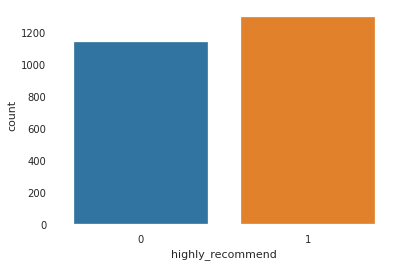

In [ ]:
sns.countplot(train['highly_recommend']);

## Calculating baseline for the target

In [ ]:
train['highly_recommend'].value_counts(normalize=True)

1    0.532133
0    0.467867
Name: highly_recommend, dtype: float64

### Baseline = ~53% of the properties I would highly recommend
_________________

### Logistic regression with ordinal encoding




In [ ]:
# Encoding
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# Imputing
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# Fitting the model!
log_reg_cv = LogisticRegressionCV()
log_reg_cv.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [ ]:
# getting accuracy score with y_pred

y_pred = log_reg_cv.predict(X_val_scaled)
print('Logistic Regression Accuracy Score:', accuracy_score(y_val, y_pred))

Logistic Regression Accuracy Score: 0.6481178396072013


## WIth Logistic Regression I beat the baseline with an accuracy score of 65%




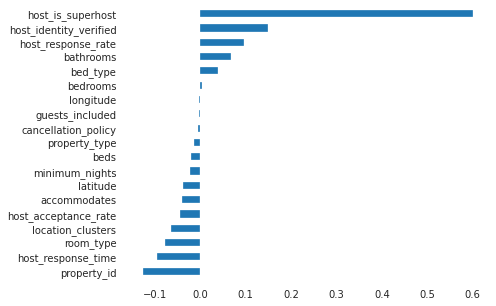

In [ ]:
# plotting coefficients

coefficients = pd.Series(log_reg_cv.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh(figsize = (6.5, 5));

### Decision Tree Classifier using Ordinal Encoding



In [ ]:
dtc = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42)
)

# fit the pipeline on train
dtc.fit(X_train, y_train)

#Score on train, Val
print('Decision Tree Validation Accuracy', dtc.score(X_val, y_val))

# predict on test
y_pred = dtc.predict(X_test)

Decision Tree Validation Accuracy 0.5973813420621932


## I beat the baseline fitting a Decision Tree Classifier model with a validation score of 59%

## Decision tree visual

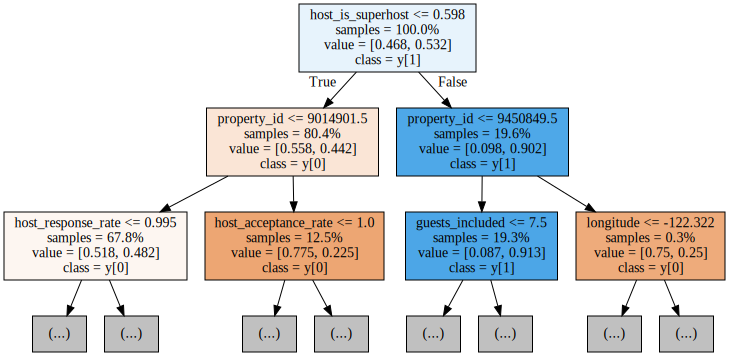

In [ ]:
model = dtc.named_steps['decisiontreeclassifier']
encoder = dtc.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=2, 
                           feature_names=encoded_columns,
                           class_names=True, 
                           impurity=False, 
                           filled=True, 
                           proportion=True,
                             rounded=False)   
display(graphviz.Source(dot_data))

### Random Forest Classifier using Ordinal Encoding







In [ ]:
rf = make_pipeline(
    FunctionTransformer(validate=False), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print('Random Forest Validation Accuracy:', accuracy_score(y_val, y_pred))

Random Forest Validation Accuracy: 0.6481178396072013


## The Random Forest Classifier model calculated a validation score of 66%

## Predictive modeling

In [ ]:
# Prediction accuracy and recall score with validation 
#from random forest classifier

rf_predict = rf.predict(X_val)

print("Predicted Accuracy Score:", accuracy_score(y_val, rf_predict))
print("Recall Score:", recall_score(y_val, rf_predict))

Predicted Accuracy Score: 0.6481178396072013
Recall Score: 0.6568627450980392


## The predicted accuracy score for the Random Forest 66% which is the same as the validation score. The recall score is 68%.

## Confusion Matrix for the Random Forest model

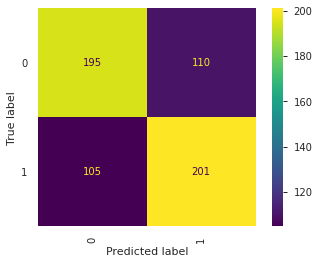

In [ ]:
plot_confusion_matrix(rf, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

## Precision and Recall from our confusion matrix

In [ ]:
# classification report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       305
           1       0.65      0.66      0.65       306

    accuracy                           0.65       611
   macro avg       0.65      0.65      0.65       611
weighted avg       0.65      0.65      0.65       611



In [ ]:
# predictions for highly_recommend

correct_predictions_highly_recommend = 207 + 194
incorrect_predictions_highly_recommend = 99 +111

total_predictions_highly_recommend = correct_predictions_highly_recommend  + incorrect_predictions_highly_recommend 

print('Correct Predictions for Highly Recommend:', correct_predictions_highly_recommend )
print('Total Predictions for Highly Recommend:', total_predictions_highly_recommend )

Correct Predictions for Highly Recommend: 401
Total Predictions for Highly Recommend: 611


## Precision (how many times the model was right) is high for the 1 class OR would highly recommend



In [ ]:
# precision

precision = correct_predictions_highly_recommend / total_predictions_highly_recommend 

print('Precision for Highly Recommend:', precision)

Precision for Highly Recommend: 0.6563011456628478


## Recall (how many times you found what you were looking for) is VERY high for the 1 class OR highly recommend

In [ ]:
# Recall: actual = column 1 total

actual_highly_recommend = 326
recall = correct_predictions_highly_recommend / actual_highly_recommend

print('Recall for Highly Reccomend:', recall)

Recall for Highly Reccomend: 1.2300613496932515


-----
## Feature Importances of the Random Forest model

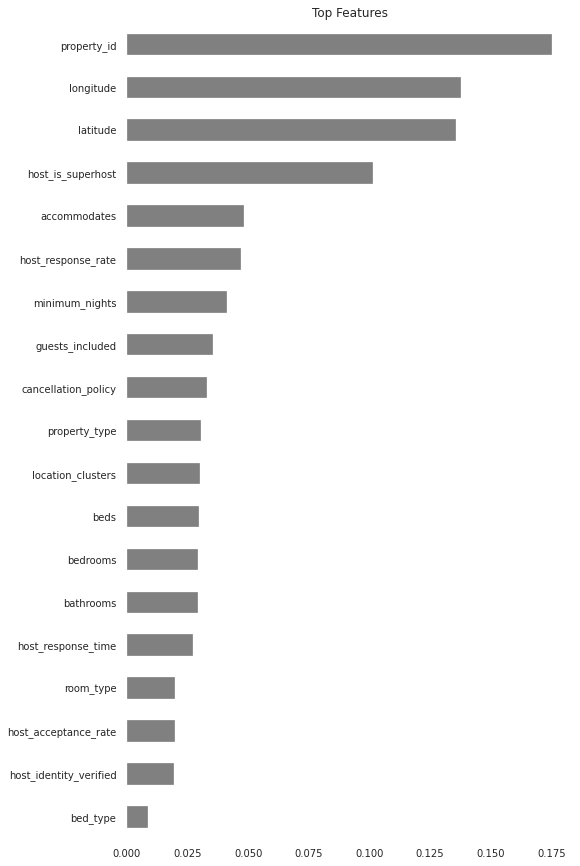

In [ ]:
# Get feature importances
rf_imp = rf.named_steps['randomforestclassifier']
importances = pd.Series(rf_imp.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt
n = 20
plt.figure(figsize=(8,15))
plt.title(f'Top Features')
importances.sort_values()[-n:].plot.barh(color='grey');

## According to the chart these are the top 4 important features:
* property_id
* longitude
* latitude
* host_is_superhost  


## The remaining features start to drop in importance



___
## Permutation of a feature

In [ ]:
# Permutation Importances
# Property ID, Long/Lat are our location indicators
# BUT how important is host_is_superhost?

feature = 'host_is_superhost'
print(X_val[feature].head())
print()
print(X_val[feature].value_counts())

3465    1.0
2522    1.0
3538    0.0
1283    0.0
2681    0.0
Name: host_is_superhost, dtype: float64

0.0    493
1.0    118
Name: host_is_superhost, dtype: int64


In [ ]:
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val_permuted[feature])

In [ ]:
acc = rf.score(X_val, y_val)
acc_permuted = rf.score(X_val_permuted, y_val)

print(f'Validation accuracy with {feature}:', acc)
print(f'Validation accuracy with {feature} permuted:', acc_permuted)
print(f'Permutation importance:', acc - acc_permuted)

Validation accuracy with host_is_superhost: 0.6481178396072013
Validation accuracy with host_is_superhost permuted: 0.5891980360065466
Permutation importance: 0.05891980360065463


### It appears that host_is_superhost has a low permutation importance but the validation accuracy score for host_is_superhost along with it's permutation is higher than the baseline
___

## Permutation Importance with eli5

In [ ]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

eli = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
eli.fit(X_train_transformed, y_train)



feature_names = X_val.columns.tolist()

permuter = PermutationImportance(
    eli,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0498 ± 0.0320,host_is_superhost
0.0118 ± 0.0136,minimum_nights
0.0115 ± 0.0264,property_id
0.0075 ± 0.0105,guests_included
0.0065 ± 0.0090,host_response_rate
0.0049 ± 0.0104,host_identity_verified
0.0026 ± 0.0132,cancellation_policy
0 ± 0.0000,host_acceptance_rate
-0.0013 ± 0.0043,bed_type
-0.0013 ± 0.0043,beds


## Fitting one last time with XGBClassifier

In [ ]:
XGB_Class = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    XGBClassifier(n_estimators=1000, n_jobs=-1),   
)




XGB_Class.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=1000, n_jobs=-1, nthread=None,
                               objective='binar

In [ ]:
from sklearn import  metrics, model_selection

y_pred= XGB_Class.predict(X_test)
print('XG Booster Accuracy Score:', metrics.accuracy_score(y_test, y_pred))

XG Booster Accuracy Score: 0.6295811518324608


An XG Booster model only gave me a 64% accuracy score, which beats the baseline and the Decision Tree model
________

## ROC Curve and ROC/AUC Scores
* I will create a plot visualizing the ROC/AUC scores for all 4 models that I have fit with
* This will show me the best fit model
* Will have 4 roc/auc scores 

In [ ]:


# Setting y predictive probability for the Logistic Regression model 
y_pred_prob_log = log_reg_cv.predict_proba(X_val_scaled)[:, -1]
# Defining fpr, tpr, thresholds
fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_prob_log)

# Setting y predictive probability for the Decision Tree model
y_pred_prob_dtc = dtc.predict_proba(X_val)[:, -1]
# Defining fpr, tpr, thresholds
fpr2, tpr2, thresholds2 = roc_curve(y_val, y_pred_prob_dtc)

# Setting y predictive probability for the Random Forest model
y_pred_prob_rf = rf.predict_proba(X_val)[:, -1]
# Defining fpr, tpr, thresholds
fpr3, tpr3, thresholds3 = roc_curve(y_val, y_pred_prob_rf)

# Setting y predictive probability for the XGB model
y_pred_prob_xgb = XGB_Class.predict_proba(X_val)[:, -1]
# Defining fpr, tpr, thresholds
fpr4, tpr4, thresholds4 = roc_curve(y_val, y_pred_prob_xgb)

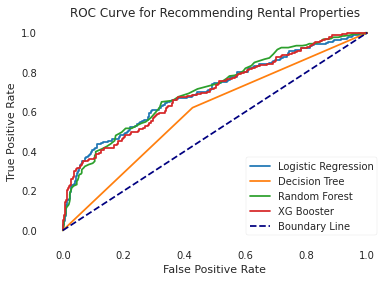

In [ ]:
# plotting all fits

plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Decision Tree')
plt.plot(fpr3, tpr3, label='Random Forest')
plt.plot(fpr4, tpr4, label='XG Booster')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label= 'Boundary Line')

plt.legend()

plt.title('ROC Curve for Recommending Rental Properties')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

When looking at the visual you can see:
* Random Forest fit the best, with Logistic Regression and XG Boost coming very close
* Logistic Regression is close to the border of True Positive and False Positive

In [ ]:
# scores

print('Logisitic Regression ROC/AUC Score:', roc_auc_score(y_val, y_pred_prob_log))
print('Decision Tree ROC/AUC Score:', roc_auc_score(y_val, y_pred_prob_dtc))
print('Random Forest ROC/AUC Score:', roc_auc_score(y_val, y_pred_prob_rf))
print('XG Booster ROC/AUC Score:', roc_auc_score(y_val, y_pred_prob_xgb))

Logisitic Regression ROC/AUC Score: 0.7032894031929713
Decision Tree ROC/AUC Score: 0.5973427622415086
Random Forest ROC/AUC Score: 0.7093110468231009
XG Booster ROC/AUC Score: 0.6982535090538947


The scores above are clearly reflected in the visual, here they are rounded to 2 decimal places
* Logisitic Regression ROC/AUC Score: 0.70
* Decision Tree ROC/AUC Score: 0.61
* Random Forest ROC/AUC Score: 0.71
* XG Booster ROC/AUC Score: 0.70

# THE END